In [1]:
import math, operator
from collections import Counter, defaultdict
from __future__ import division

class KNN(object):
    def __init__(self, K):
        self.K = K
        self.data = []
    
    def train(self, data):
        self.data = data
    
    def classify(self, test_data):
        out = []
        for X, Y, _ in test_data:
            distances = []
            for X_, Y_, cls_ in self.data:
                distances.append(( math.sqrt( (X-X_)**2 + (Y-Y_)**2 ) , cls_ ))
            closestK = sorted(distances, key=operator.itemgetter(0))[:self.K]
            classes = Counter()
            for point in closestK:
                classes[point[1]] += 1 
            
            out.append(classes.most_common(1)[0][0])
        return out

# scores for binary classification
def compute_scores(Y, Y_correct):
    assert len(Y) == len(Y_correct)
    stats = Counter()
    for i in range(len(Y)):
        stats['total'] += 1
        stats['correct'] += 1 if Y[i] == Y_correct[i] else 0
        # class A - 0, class B - 1
        stats['TP_a'] += 1 if Y[i] == Y_correct[i] and Y[i] == 0 else 0
        stats['TP_b'] += 1 if Y[i] == Y_correct[i] and Y[i] == 1 else 0
        stats['FP_a'] += 1 if Y[i] == 0 and Y_correct[i] == 1 else 0
        stats['FP_b'] += 1 if Y[i] == 1 and Y_correct[i] == 0 else 0
    stats['FN_a'] = stats['FP_b']
    stats['FN_b'] = stats['FP_a']
    
    P_a = stats['TP_a'] / (stats['TP_a'] + stats['FP_a'])
    P_b = stats['TP_b'] / (stats['TP_b'] + stats['FP_b'])
    
    R_a = stats['TP_a'] / (stats['TP_a'] + stats['FN_a'])
    R_b = stats['TP_b'] / (stats['TP_b'] + stats['FN_b'])
    
    F1_a = 2 * P_a * R_a / (P_a + R_a)
    F1_b = 2 * P_b * R_b / (P_b + R_b)
    
    Acc = stats['correct'] / stats['total']
    
    return {"A": Acc, 
            "P_a": P_a, "P_b": P_b, 
            "R_a": R_a, "R_b": R_b, 
            "F1_a": F1_a, "F1_b": F1_b}
        

In [2]:
%matplotlib inline
import numpy as np
data = []
with open("chips.txt") as dataset:
    for line in dataset:
        l = line.strip().split(',')
        l[-1] = int(l[-1])
        l[:2] = map(float, l[:2])
        data.append(tuple(l))
print data[:5]

[(0.051267, 0.69956, 1), (-0.092742, 0.68494, 1), (-0.21371, 0.69225, 1), (-0.375, 0.50219, 1), (-0.51325, 0.46564, 1)]


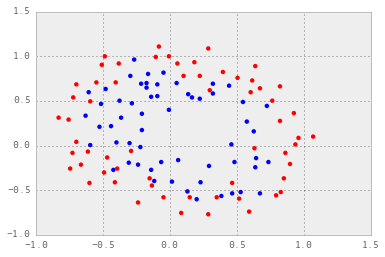

In [3]:
import matplotlib.pyplot as plt
def print_set(data):
    colors = ['red', 'blue']
    for X, Y, cls in data:
        plt.scatter(X, Y, c=colors[cls], label=colors[cls], edgecolors='none')
    plt.grid(True)
    plt.show()
    
print_set(data)

In [4]:
from sklearn import cross_validation
folds = cross_validation.KFold(
    len(data), n_folds=10, random_state=0, shuffle=True)

A


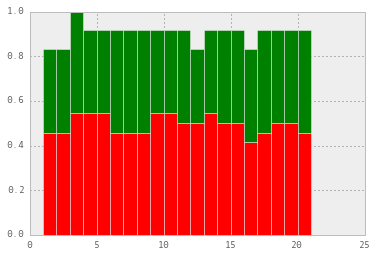

F1_a


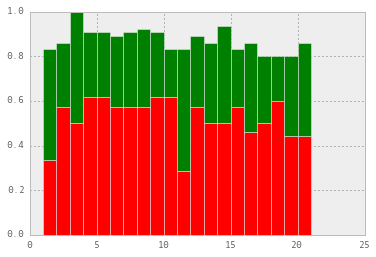

F1_b


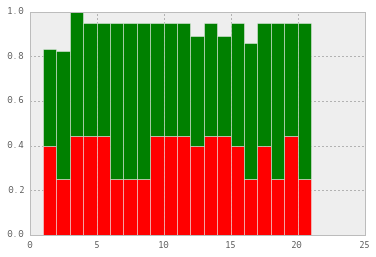

In [5]:
# performances = { K (num of neighbours) => { Rec => {}, Prec => {}, Acc => {}, Fm => {}}}
performances = defaultdict(defaultdict)

for k in range(1, 21):
    for fold in folds:
        train_indices, test_indices = fold
        TRAIN = [d for i, d in enumerate(data) if i in train_indices]
        TEST = [d for i, d in enumerate(data) if i in test_indices]

        knn = KNN(k)
        knn.train(TRAIN)
        labels = knn.classify(TEST)
        correct_labels = [l[-1] for l in TEST]
        scores = compute_scores(labels, correct_labels)
        for metric, v in scores.items():
            try:
                performances[k][metric]['worst'] = min((performances[k][metric]['worst'], v))
            except KeyError:
                performances[k][metric] = {'worst': v, 'best': 0}
            
            performances[k][metric]['best'] = max((performances[k][metric]['best'], v))

def print_metric_graph(metric, performances):
    best = [performances[k][metric]['best'] - performances[k][metric]['worst'] \
            for k in performances]
    worst = [performances[k][metric]['worst'] for k in performances]
    width = 1
    plt.bar(performances.keys(), worst, width, color='r')
    plt.bar(performances.keys(), best, width, color='g', bottom=worst)
    plt.ylim(0, 1)
    plt.show()

    
for metric in "A F1_a F1_b".split():
    print metric
    print_metric_graph(metric, performances)